# Denoising with generative models

## Pytorch tests

### Creating a few tensors as tests

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import matplotlib.pyplot as plt

In [8]:
x = torch.rand(1, 1, 1024) # (batch_size, n_channels, dim)
y = torch.rand(1, 1, 1024)

In [9]:
x

tensor([[[0.2493, 0.0235, 0.3726,  ..., 0.5709, 0.3134, 0.9624]]])

In [10]:
y

tensor([[[0.3985, 0.4221, 0.1960,  ..., 0.0936, 0.4269, 0.9995]]])

In [11]:
z = torch.cat((x,y), 1)

In [12]:
z

tensor([[[0.2493, 0.0235, 0.3726,  ..., 0.5709, 0.3134, 0.9624],
         [0.3985, 0.4221, 0.1960,  ..., 0.0936, 0.4269, 0.9995]]])

In [13]:
w = torch.rand(1, 4, 1024)

In [14]:
w

tensor([[[0.5144, 0.1326, 0.5184,  ..., 0.5034, 0.9790, 0.5999],
         [0.2514, 0.4779, 0.5339,  ..., 0.0037, 0.8894, 0.6243],
         [0.3352, 0.7154, 0.9672,  ..., 0.5820, 0.7565, 0.4447],
         [0.4459, 0.7305, 0.5374,  ..., 0.9348, 0.0710, 0.6991]]])

### Subpixel operation

In [15]:
# from https://gist.github.com/davidaknowles/6e95a643adaf3960d1648a6b369e9d0b
def pixel_shuffle_1d(x, upscale_factor):
    batch_size, channels, steps = x.size()
    channels //= upscale_factor
    input_view = x.contiguous().view(batch_size, channels, upscale_factor, steps)
    shuffle_out = input_view.permute(0, 1, 3, 2).contiguous()
    return shuffle_out.view(batch_size, channels, steps * upscale_factor)

In [16]:
pixel_shuffle_1d(z, 2)

tensor([[[0.2493, 0.3985, 0.0235,  ..., 0.4269, 0.9624, 0.9995]]])

In [17]:
pixel_shuffle_1d(w, 2)

tensor([[[0.5144, 0.2514, 0.1326,  ..., 0.8894, 0.5999, 0.6243],
         [0.3352, 0.4459, 0.7154,  ..., 0.0710, 0.4447, 0.6991]]])

### Generate base sizes and count for each level

In [18]:
# this is what they implemented in their git project

def get_sizes_for_layers(B):
    n_channels = []
    size_filters = []
    #test = []
    for b in range(1, B+1):
        n_channels.append(min(2**(6 + b), 512)) # They wrote max in paper, but min in code
        size_filters.append(max(2**(7-b) + 1, 9)) # They wrote min in paper, but max in code
        #test.append(min(2**(7+(B-b+1)), 512))
    
    return n_channels, size_filters

In [19]:
B = 4
n_channels, size_filters = get_sizes_for_layers(B)

In [20]:
n_channels, size_filters #Checking values

([128, 256, 512, 512], [65, 33, 17, 9])

### Generate correct parameters for up and down

In [21]:
# The input channel count is equal to the the output channel count of the previous layer
# Input will be all the channel counts, shifted to the right with a 1 before
def args_down(n_channels, size_filters):
    return zip([1] + n_channels[:-1], n_channels, size_filters)

# Input filter count is the size of the bottlneck for the first up layer
# And then it will be the count of the previous up layer, which is equal to twice the count of the down layer
# (since we do some stacking with the skip connections)

# Output filter count  will be twice the count of the down layer 
# so that after the subpixel we get the same count as in the down layer
# and we can stack them together
def args_up(n_channels, size_filters):
    return zip([int(n_channels[-1]/2)] + n_channels[::-1][:-1], n_channels[::-1], size_filters[::-1])

In [22]:
list(args_down(n_channels, size_filters))

[(1, 128, 65), (128, 256, 33), (256, 512, 17), (512, 512, 9)]

In [23]:
list(args_up(n_channels, size_filters))

[(256, 512, 9), (512, 512, 17), (512, 256, 33), (256, 128, 65)]

#### And if we use the arguments, we get the same parameters as the manually defined ones

In [24]:
for n_ch_in, n_ch_out, size in args_down(n_channels, size_filters):
    print(n_ch_in, n_ch_out, size)
print(n_channels[-1], size_filters[-1])
            
for n_ch_in, n_ch_out, size in args_up(n_channels, size_filters):
    print(n_ch_in*2, n_ch_out*2, size)
                                            
print(n_channels[0]*2, 9)

1 128 65
128 256 33
256 512 17
512 512 9
512 9
512 1024 9
1024 1024 17
1024 512 33
512 256 65
256 9


## Neural Network architecture

In [25]:
class Subpixel(nn.Module):
    def __init__(self):
        super(Subpixel, self).__init__()
           
    def forward(self, x):
        y = pixel_shuffle_1d(x, 2)
        return y

In [26]:
class Concat(nn.Module):
    def __init__(self):
        super(Concat, self).__init__()
           
        
    def forward(self, x1, x2):
        y = torch.cat((x1, x2), 1) # concat on dim 1 (channel dimension)
        return y

In [27]:
class Add(nn.Module):
    def __init__(self):
        super(Add, self).__init__()
           
        
    def forward(self, x1, x2):
        y = torch.add(x1, x2)
        return y

In [28]:
class Downsampling(nn.Module):
    
    def __init__(self, in_ch, out_ch, size, verbose=0):
        super(Downsampling, self).__init__()
        self.verbose = verbose
        
        self.conv = nn.Sequential(
            # We need a padding mode = same to get the same behavior as the paper
            # But it doesn't seem to exist in pytorch
            nn.Conv1d(in_channels=in_ch, out_channels=out_ch, kernel_size=size, stride=2, padding_mode='zeros', padding=int((size-1)/2)), 
            nn.LeakyReLU(0.2)
        )
        
    def forward(self, x):
        if self.verbose: print("Before conv down : " + str(x.size()))
        y = self.conv(x)
        if self.verbose: print("After conv down : " + str(y.size()))
        return y

In [29]:
class Bottleneck(nn.Module):
    def __init__(self, ch, size, verbose=0):
        super(Bottleneck, self).__init__()
        self.verbose = verbose
        self.conv = nn.Sequential(
            # We need a padding mode = same to get the same behavior as the paper
            # But it doesn't seem to exist in pytorch
            nn.Conv1d(in_channels=ch, out_channels=ch, kernel_size=size, stride=2, padding_mode='zeros', padding = int((size-1)/2)), 
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2)
        )
        
    def forward(self, x):
        if self.verbose: print("Bottleneck before: " + str(x.size()))
        y = self.conv(x)
        if self.verbose: print("Bottleneck after: " + str(y.size()))
        return y

In [30]:
class Upsampling(nn.Module):
    def __init__(self, in_ch, out_ch, size, verbose=0):
        super(Upsampling, self).__init__()
        self.verbose = verbose
        self.conv = nn.Sequential(
            # We need a padding mode = same to get the same behavior as the paper
            # But it doesn't seem to exist in pytorch
            nn.Conv1d(in_channels=in_ch, out_channels=out_ch, kernel_size=size, stride=1, padding_mode='zeros', padding = int((size-1)/2)),
            nn.Dropout(p=0.5),
            nn.ReLU()
        )
        self.subpixel = Subpixel()
        self.concat = Concat()
        
    def forward(self, x1, x2):
        if self.verbose: print("Upsampling before: " + str(x1.size()))
        y = self.conv(x1)
        if self.verbose: print("Upsampling conv: " + str(y.size()))
        y = self.subpixel(y)
        if self.verbose: print("Upsampling subpixel: " + str(y.size()))
        y = self.concat(y, x2)
        if self.verbose: print("Upsampling concat: " + str(y.size()))
        return y

In [31]:
class LastConv(nn.Module):
    def __init__(self, in_ch, size, verbose=0):
        super(LastConv, self).__init__()
        self.verbose = verbose
        self.conv = nn.Conv1d(in_channels=in_ch, out_channels=2, kernel_size=9, stride=1, padding_mode='zeros', padding = int((size-1)/2))
        self.subpixel = Subpixel()
        self.add = Add()
           
        
    def forward(self, x1, x2):
        if self.verbose: print("Final before: " + str(x1.size()))
        y = self.conv(x1)
        if self.verbose: print("Final conv: " + str(y.size()))
        y = self.subpixel(y)
        if self.verbose: print("Final subpixel: " + str(y.size()))
        y = self.add(y, x2)
        if self.verbose: print("Final add: " + str(y.size()))
        return y

In [38]:
class Net(nn.Module):

    def __init__(self, depth, verbose=0):
        super(Net, self).__init__()
        self.verbose = verbose
        
        
        
        # Manual definition
        
        
        #B = 4
        #n_channels= [128, 256, 512, 512] # max(2^(6+b), 512) 
        #size_filters = [65, 33, 17, 9] # min(2^(7−b) + 1, 9)
        
        #self.down1 = Downsampling(1, 128, 63)
        #self.down2 = Downsampling(128, 256, 33)
        #self.down3 = Downsampling(256, 512, 17)
        #self.down4 = Downsampling(512, 512, 9)
        #self.bottleneck = Bottleneck(512, 9)
        #self.up1 = Upsampling(int((512/2)*2), 512*2, 9)
        #self.up2 = Upsampling(512*2, 512*2, 17)
        #self.up3 = Upsampling(512*2, 256*2, 33)
        #self.up4 = Upsampling(256*2, 128*2, 63)
        #self.last = LastConv(128*2, 9)

        
        # Automatic definition, seems to work :
        
        B = depth
        n_channels, size_filters = get_sizes_for_layers(B)
        
        # Downsampling
        self.down = []
        for n_ch_in, n_ch_out, size in args_down(n_channels, size_filters):
            self.down.append(Downsampling(n_ch_in, n_ch_out, size, verbose))
            
        # Bottlneck
        self.bottleneck = Bottleneck(n_channels[-1], size_filters[-1], verbose)
        
        # Upsampling
        self.up = []
        for n_ch_in, n_ch_out, size in args_up(n_channels, size_filters):
            self.up.append(Upsampling(n_ch_in*2, n_ch_out*2, size, verbose))
              
        # Final layer
        self.last = LastConv(n_channels[0]*2, 9, verbose)
        
        
        

    def forward(self, x):

        # Manual 
        
        #x1 = self.down1(x)
        #x2 = self.down2(x1)
        #x3 = self.down3(x2)
        #x4 = self.down4(x3)
        #b = self.bottleneck(x4)
        #y = self.up1(b, x4)
        #y = self.up2(y, x3)
        #y = self.up3(y, x2)
        #y = self.up4(y, x1)
        #y = self.last(y, x)
        
        # Automatic
        
        # Downsampling
        down_out = []
        xi = x
        for i in range(len(self.down)):
            xi = self.down[i](xi)
            down_out.append(xi)
            
        # Bottleneck
        b = self.bottleneck(xi)
        
        # Upsampling
        y = b
        for i in range(len(self.up)):
            y = self.up[i](y, down_out[-(i+1)])
            
        # Final layer
        y = self.last(y, x)
       
        return y
    

#print(net)

In [83]:
# Warning : Depth must be < log(input size) if input is a power of 2
# Otherwise this limit is lower : D  = max (i) s.t. inputsize/2^i is integer

net = Net(8, verbose = 0)
INPUT_SIZE = 2048
net = net.eval()
input = torch.randn(1, 1, INPUT_SIZE, requires_grad=False) # attention active dropout (a voir)
# check the difference between net.eval() and net.train(), 
# look at the self.training attribute, it might be necessary for the custom layers.
print("input : " + str(input))
out = net(input)
print("output" + str(out))


input : tensor([[[-2.2206, -1.8321, -0.8282,  ..., -1.2258,  0.0595,  0.9550]]])
outputtensor([[[-2.2349, -1.8494, -0.9074,  ..., -1.2824,  0.0081,  0.9073]]],
       grad_fn=<AddBackward0>)


In [85]:
net = net.eval()
print("input : " + str(input))
output = net(input)
print("output" + str(out))
print("input : " + str(input))
out = net(input)
print("output" + str(out))

input : tensor([[[-2.2206, -1.8321, -0.8282,  ..., -1.2258,  0.0595,  0.9550]]])
outputtensor([[[-2.2527, -1.8430, -0.9007,  ..., -1.3056,  0.0180,  0.9049]]],
       grad_fn=<AddBackward0>)
input : tensor([[[-2.2206, -1.8321, -0.8282,  ..., -1.2258,  0.0595,  0.9550]]])
outputtensor([[[-2.2661, -1.8192, -0.8731,  ..., -1.2782,  0.0064,  0.9020]]],
       grad_fn=<AddBackward0>)


In [41]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

# in your training loop:

#print(list(net.parameters()))

optimizer.zero_grad()   # zero the gradient buffers
out = net(input)
loss = criterion(out, torch.randn(1, 1, INPUT_SIZE))
loss.backward()
optimizer.step()  

#print(list(net.parameters())) # We can check that the parameters have changed.

In [82]:

print("input : " + str(input))
out = net(input)
print("output" + str(out))

input : tensor([[[-0.6557,  0.2132,  1.0301,  ...,  0.1582, -2.6138, -1.1125]]])
outputtensor([[[-0.6124,  0.3140,  0.9034,  ...,  0.1599, -2.6230, -0.8979]]],
       grad_fn=<AddBackward0>)


In [3]:
filename = "/mnt/Data/maestro-v2.0.0/2004/MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav.wav"
waveform, sample_rate = torchaudio.load(filename)

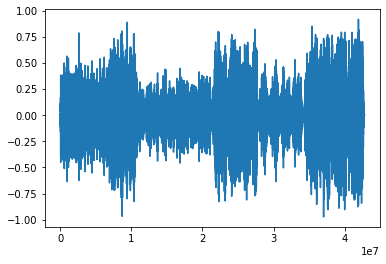

In [15]:
plt.figure()
plt.plot(waveform[0,:].numpy())

In [10]:
input = waveform[0]

In [11]:
input

tensor([0.0005, 0.0007, 0.0007,  ..., 0.0041, 0.0041, 0.0042])

Shape of transformed waveform: torch.Size([2, 2672261])


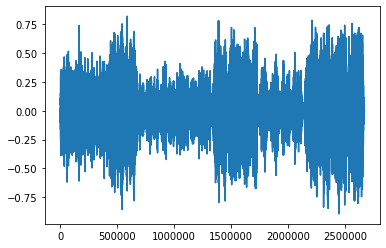

In [17]:
new_sample_rate = sample_rate/16

transformed = torchaudio.transforms.Resample(sample_rate, new_sample_rate)(waveform)


print("Shape of transformed waveform: {}".format(transformed.size()))

plt.figure()
plt.plot(transformed[0,:].numpy())


In [34]:
out = torch.cat((transformed0, transformed1), 0)

In [2]:
torchaudio.save("/mnt/Data/maestro-v2.0.0/out.mp3", out, new_sample_rate, precision=16, channels_first=True)

NameError: name 'out' is not defined

In [ ]:
# input downsampling : soit doubler pixels sur interpolation

# Essayer de faire un network identié


In [2]:
loss = [0.0008390009170398116, 0.000655410229228437, 0.0005588991334661841, 0.0004300789150875062, 0.0003297694493085146, 0.0002594758407212794, 0.0002273184945806861, 0.0001620490220375359, 8.730070112505928e-05, 0.0002593088720459491, 8.405254629906267e-05, 8.988057379610837e-05, 0.0001238928671227768, 0.00016848824452608824, 0.00010281649883836508, 0.0002348031266592443, 0.00013156337081454694, 0.00014760976773686707, 0.00017685783677734435, 0.00013016008597332984, 7.5252064561937e-05, 0.00011085756705142558, 0.00013003221829421818, 6.748969462933019e-05, 5.497725942404941e-05, 0.00011936124064959586, 8.52036610012874e-05, 5.9352038078941405e-05, 7.048975385259837e-05, 6.616163591388613e-05, 9.045869228430092e-05, 6.23676460236311e-05, 6.65065017528832e-05, 8.102798892650753e-05, 6.56345728202723e-05, 5.997294283588417e-05, 5.7421573728788644e-05, 4.9465030315332115e-05, 3.770300099859014e-05, 3.903453398379497e-05, 7.419372559525073e-05, 6.320970715023577e-05, 3.2322459446731955e-05, 5.241789040155709e-05, 6.538881279993802e-05, 3.518908852129243e-05, 4.960340811521746e-05, 4.1261795558966696e-05, 2.860366839740891e-05, 6.175053567858413e-05, 5.936433808528818e-05, 3.383681905688718e-05, 3.577697862056084e-05, 3.358021058375016e-05, 5.422195317805745e-05, 3.0085539037827402e-05, 3.164291410939768e-05, 5.069940380053595e-05, 2.2674781575915404e-05, 4.852132042287849e-05, 3.5734403354581445e-05, 2.8887168809887953e-05, 3.5063247196376324e-05, 4.659250771510415e-05, 4.139330849284306e-05, 2.70798773271963e-05, 3.414817911107093e-05, 3.670871228678152e-05, 2.678853525139857e-05, 1.7521721019875258e-05, 6.020520959282294e-05, 3.9104292227420956e-05, 4.5606113417306915e-05, 4.851707490161061e-05, 3.421917062951252e-05, 5.41179470019415e-05, 3.353769352543168e-05, 3.009432475664653e-05, 3.295214628451504e-05, 2.4049684725468978e-05, 3.439633292146027e-05, 4.1930805309675634e-05, 2.4152453988790512e-05, 2.958717232104391e-05, 1.9118970158160664e-05, 2.2928677935851738e-05, 2.634805059642531e-05, 2.3413369490299374e-05, 3.5052373277721927e-05, 2.5921399355866015e-05, 4.2488456529099494e-05, 3.589350308175199e-05, 2.4359826056752354e-05, 3.5040353395743296e-05, 2.8995647880947217e-05, 2.783156742225401e-05, 3.1372714147437364e-05, 2.686695552256424e-05, 2.5199318770319223e-05, 1.9791868908214383e-05, 2.8431721148081124e-05, 2.6515286663197912e-05, 3.454523903201334e-05, 2.6106003133463673e-05, 2.2539825295098126e-05, 2.768476406345144e-05, 2.5551491489750333e-05, 1.4432625903282315e-05, 1.803710256353952e-05, 2.8709495381917804e-05, 1.7959278920898214e-05, 1.9469600374577567e-05, 1.8742437532637268e-05, 2.3810269340174273e-05, 1.5511115634581074e-05, 2.693030910450034e-05, 2.3705844796495512e-05, 2.360700091230683e-05, 2.2928041289560497e-05, 1.9219856767449528e-05, 1.6060728739830665e-05, 2.271575795020908e-05, 1.6948133634286933e-05, 1.4545010344590992e-05, 2.57137326116208e-05, 3.372557694092393e-05, 2.937880708486773e-05, 1.6248399333562702e-05, 1.4063843082112726e-05, 1.643177711230237e-05, 1.8712220480665565e-05, 1.3670422049472108e-05, 1.702915324131027e-05, 1.9108783817500807e-05, 1.2554396562336478e-05, 2.0530551410047337e-05, 2.2059968614485115e-05, 2.0266266801627353e-05, 1.8945547708426602e-05, 1.706575494608842e-05, 3.207133704563603e-05, 1.3409925486485008e-05, 2.8842674510087818e-05, 1.695361061138101e-05, 1.552145113237202e-05, 2.099793891829904e-05, 2.8125827157055028e-05, 1.9721774151548743e-05, 1.6831905668368563e-05, 2.061776103801094e-05, 1.782964864105452e-05, 1.4957594430597965e-05, 1.531409907329362e-05, 1.4994009688962251e-05, 2.5462544726906344e-05, 2.1392368580563925e-05, 1.526329288026318e-05, 1.4137614925857633e-05, 2.5028786694747396e-05, 2.1089790607220493e-05, 1.675095882092137e-05, 1.4379571439349093e-05, 1.3048761502432171e-05, 1.390087345498614e-05, 1.785170752555132e-05, 1.5771895050420426e-05, 1.8458249542163685e-05, 1.921199873322621e-05, 1.3150603081157897e-05, 1.7563144865562208e-05, 2.0419913198566064e-05, 1.876370151876472e-05, 1.2026210242765956e-05, 1.7368309272569604e-05, 1.2359850188659038e-05, 1.495528340456076e-05, 1.5072220776346512e-05, 1.9082064682152122e-05, 1.6815823983051814e-05, 1.8179029211751185e-05, 1.0747925443865824e-05, 1.2485932529671118e-05, 1.9014529243577272e-05, 1.4840682524663862e-05, 2.0937895897077397e-05, 1.59078754222719e-05, 1.4904604540788569e-05, 2.2987087504589e-05, 1.243421957042301e-05, 1.2783730198862031e-05, 1.6779442375991493e-05, 1.3641312762047164e-05, 1.3960797332401853e-05, 1.3529201169149019e-05, 1.808498018363025e-05, 1.428188170393696e-05, 1.704982787487097e-05, 1.5241380424413364e-05, 1.9078715922660194e-05, 1.030388921208214e-05, 1.5611527487635612e-05, 1.197105575556634e-05, 1.8983140762429684e-05, 1.660833731875755e-05, 1.1952299246331677e-05, 1.1417094356147572e-05, 1.6175006749108434e-05, 1.2097859325876925e-05, 1.8492915842216462e-05, 1.209269612445496e-05, 1.5212451216939371e-05, 1.9113640519208275e-05, 1.2268495993339457e-05, 1.7909602320287377e-05, 1.9974244423792697e-05, 1.0010558071371634e-05, 1.5629955669282936e-05, 1.4412346899916884e-05, 2.1911087969783694e-05, 1.750754745444283e-05, 1.082310154743027e-05, 1.459782652091235e-05 ,1.2566013538162224e-05 ,1.3371751265367493e-05 ,1.060499926097691e-05 ,2.0175000827293843e-05 ,2.141276308975648e-05 ,1.3255903468234465e-05 ,1.7055510397767648e-05 ,1.7968719475902617e-05 ,1.4370461940416135e-05 ,1.2235188478371128e-05 ,1.2293370673432946e-05 ,1.1757437277992722e-05 ,1.2105317182431463e-05 ,1.6255311493296176e-05 ,1.1896729120053351e-05 ,1.487879671913106e-05 ,1.1295608601358254e-05 ,9.25862059375504e-06 ,1.9973736925749108e-05 ,1.438514118490275e-05 ,1.2352052181086037e-05 ,1.1343625374138355e-05 ,1.3249932635517325e-05 ,1.4263965567806736e-05 ,1.2794293070328422e-05 ,1.3226572264102288e-05 ,1.719966167001985e-05 ,1.2021428119624034e-05 ,1.156050984718604e-05 ,1.230572524946183e-05 ,1.4318557077785954e-05 ,1.122141839005053e-05 ,9.986012628360186e-06 ,9.981857147067785e-06 ,1.4472951988864224e-05 ,1.168482231150847e-05 ,7.902608558651991e-06 ,1.3008877431275323e-05 ,1.6526733816135675e-05 ,1.1215872291359119e-05 ,1.4425942936213687e-05 ,1.1553041986189783e-05 ,1.4481283869827166e-05]

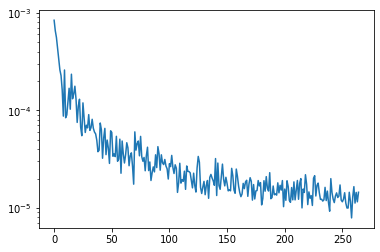

In [5]:
plt.plot(loss)
plt.yscale('log')